In [1]:
import open3d as o3d
import numpy as np

from skspatial.objects import Plane, Points
from skspatial.plotting import plot_3d
import matplotlib.pyplot as plt

import os

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


INFO - 2022-12-01 10:47:08,920 - utils - Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO - 2022-12-01 10:47:08,921 - utils - NumExpr defaulting to 8 threads.


In [ ]:
pcd = o3d.io.read_point_cloud('../../maps/flat.ply')
assert isinstance(pcd, o3d.geometry.PointCloud)
print(pcd)

In [6]:
# pcds: list[o3d.geometry.PointCloud] = []
plys_dir = '../../maps/flat_frame_separated/'

pc_fns = [fn for fn in os.listdir(plys_dir)]

def get_pc_from_fn(fn_:str):
    return o3d.io.read_point_cloud(plys_dir+fn_)

In [3]:
from datetime import datetime

now = datetime.now()

print(now.time())

13:21:56.155176


In [55]:
_pc_100 = get_pc_from_fn(pc_fns[102])
print(_pc_100)
_pc_100 = _pc_100.voxel_down_sample(voxel_size=0.1)
print(_pc_100)

# o3d.visualization.draw_geometries([_pc_100])

ps= np.asarray(_pc_100.points)
ps = np.array([p for i,p in enumerate(ps) if i%5==0])
print(ps.shape)

PointCloud with 18357 points.
PointCloud with 3292 points.
(659, 3)


In [58]:
import plotly.express as px
# df = px.data.iris()
fig = px.scatter_3d(x=ps[:,0].tolist(), y=ps[:,1].tolist(), z=ps[:,2].tolist())
fig.update_traces(marker=dict(size=3))
fig.show()
fig.write_html('test.html')

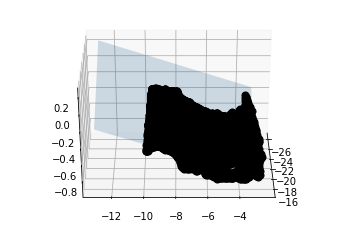

In [14]:
sk_points = Points(np.asarray(_pc_100.points))
sk_plane = Plane.best_fit(sk_points)
fig, ax = plot_3d(
    sk_points.plotter(c='k', s=50, depthshade=False),
    sk_plane.plotter(alpha=0.2, lims_x=(-5, 5), lims_y=(-5, 5)),
)
ax.view_init(30, 0)

In [ ]:
downpcd = pcd.voxel_down_sample(voxel_size=0.5)

In [ ]:
o3d.visualization.draw_geometries([downpcd])

In [ ]:
distances = [plane.distance_point(point) for point in points]
plt.hist(distances)

In [ ]:
hole_points = []
for point in points:
    if plane.distance_point(point) > 0.15:
        hole_points.append(point)


In [ ]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(hole_points)
pcd.paint_uniform_color([1.0, 0, 0])

In [ ]:
fig, ax = plot_3d(
    hole_points.plotter(c='k', s=50, depthshade=False),
    plane.plotter(alpha=0.2, lims_x=(-5, 5), lims_y=(-5, 5)),
)

ax.view_init(30, 0)

In [ ]:
inliners = []
outliners = []

for pcd in pcds:
    plane_model, inliers = pcd.segment_plane(distance_threshold=0.1,
                                             ransac_n=3,
                                             num_iterations=1000)
    [a, b, c, d] = plane_model
    print(f"Plane equation: {a:.2f}x + {b:.2f}y + {c:.2f}z + {d:.2f} = 0")

    inlier_cloud = pcd.select_by_index(inliers)
    inlier_cloud.paint_uniform_color([1.0, 0, 0])
    outlier_cloud = pcd.select_by_index(inliers, invert=True)

    inliners.append(inlier_cloud)
    outliners.append(outlier_cloud)


In [ ]:
o3d.visualization.draw_geometries([*inliners, *outliners])